In [4]:
import numpy as np 
import pandas as pd 
import os, sys, gc, warnings, psutil, random
import logging
import pickle

warnings.filterwarnings('ignore')


In [5]:
from razor.api import project_space_path
import razor
from razor import Technology, LibraryMode
import razor.flow as rf
import typing as t


In [6]:
@rf.block(executor=rf.ContainerExecutor(cores=2, memory=8192))
class Encoder():
    def run(self):

        # Read data
        grid_df = pd.read_pickle(project_space_path('/M5Forecasting/m5-simple-fe/grid_part_1.pkl'))
        TARGET = 'sales'
        
        grid_df[["d"]] = grid_df[["d"]].apply(pd.to_numeric, errors='coerce', downcast="integer")
#         logging.info(grid_df.dtypes)
        grid_df[grid_df['d']>(1913-28)][TARGET] = np.nan
        base_cols = list(grid_df)

        icols =  [
                    ['state_id'],
                    ['store_id'],
                    ['cat_id'],
                    ['dept_id'],
                    ['state_id', 'cat_id'],
                    ['state_id', 'dept_id'],
                    ['store_id', 'cat_id'],
                    ['store_id', 'dept_id'],
                    ['item_id'],
                    ['item_id', 'state_id'],
                    ['item_id', 'store_id']
                    ]

        for col in icols:
            logging.info('Encoding')
            logging.info(col)
            col_name = '_'+'_'.join(col)+'_'
            grid_df['enc'+col_name+'mean'] = grid_df.groupby(col)[TARGET].transform('mean').astype(np.float16)
            grid_df['enc'+col_name+'std'] = grid_df.groupby(col)[TARGET].transform('std').astype(np.float16)

        keep_cols = [col for col in list(grid_df) if col not in base_cols]
        grid_df = grid_df[['id','d']+keep_cols]

        logging.info('Save Mean/Std encoding')
        grid_df.to_pickle(project_space_path('/M5Forecasting/mean_encoding_df.pkl'))
        


In [7]:
encoder = Encoder()


In [9]:
p = rf.Pipeline("Mean Encoding", targets=[encoder]) 


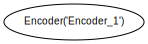

In [10]:
p.show()

In [154]:
# p.execute(wait=True)

In [155]:
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [158]:
deployed_pipeline

PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='6268a18a-e05a-11ea-b134-072aac3a2c1a', pipeline_name='Mean Encoding', pipeline_run_id='d8092ca5-9d69-4116-aa5c-4b3ee5dfcfc2', pipeline_version=None, comment=None, created_on='2020-08-17T07:22:20.072+0000', start_time=None, end_time=None, eta=0, run_at=1597648940072, run_duration=0, compute_time=0, wait_time=0, ran_by_user=RanByUser(user_name='Ayan Basak', email='ayan.basak@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='d8092ca5-9d69-4116-aa5c-4b3ee5dfcfc2', pipeline_name='Mean Encoding', pipeline_status='IN_PROGRESS', block_id='fbda057f-a9b3-4421-b1aa-32c7a53ead53', block_run_id='46c76156-5080-4c4e-9391-a6a624414ec1', block_name='Encoder_1', resource_spec=ResourceAllocated(cores=2, memory=8192, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='fbda057f-a9b3-4421-b1aa-32c7a53ead53', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-08-17T07:22:20.000+0000')], run_number=91, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='fbda057f-a9b3-4421-b1aa-32c7a53ead53', block_run_id='46c76156-5080-4c4e-9391-a6a624414ec1', block_name='Encoder_1', technology='PYTHON', log_path=None, input_parameters='{}', output_parameters=None, status='READY_TO_GO', created_at='2020-08-17T07:22:20.103+0000', queued_at='2020-08-17T07:22:20.000+0000', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[], resource_allocated=ResourceAllocated(cores=2, memory=8192, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'))], pipeline_json='{\n  "id": "6268a18a-e05a-11ea-b134-072aac3a2c1a",\n  "projectId": "c0b26d85-a4c9-44f5-9d0e-f540dd2de644",\n  "name": "Mean Encoding",\n  "description": "",\n  "blocks": [\n    {\n      "name": "Encoder_1",\n      "id": "fbda057f-a9b3-4421-b1aa-32c7a53ead53",\n      "artifact_id": null,\n      "class_name": "Encoder",\n      "code": "eJxtU0Fv0zAUTtpsrTYxJDQY3KaB0Aa0W1nbMQlxoMCBaBXauCLLtZ0mq2OH2AYNUQkJTbv4NnOHXwrPadB2mHPwe+/z83vfy+cf0S/bDKplNwiXhhYZmXHWvWY7+wCVLD2jJdYMqRnjTEuBCMdKuUu3nQZ2HeV4dhNm2xOTcZ0J5WykzwoGQdt6K4ikrHT2fom/ybJLZMm6Ey7JTNWbs0uvvQHHz90cUhCikiDkxspuToaDwz4dHuwN2H6/T/cPGe73n2NyMKS9w/6w78baHUPWtl1BKJfUcAaZtg0OzoQ3m6URDvpeQ0nGOUqMIDqTomZz+4pNBUEYordQTQX959EeAYuP3jmHettxGAfxUhzFo9ETGtKAB/Ow2sN5o9ob8+b38HdTR7TxM/wTziManARuHAf26e7R4B0MgWAFBaa7+aCjsrzgrJOw3WmZUVTgUqNet5hxdwHElgssKIYxtbicTiHFQaj+W6slw5BQe3eKUp4yopEqMGFwj06dhhsixXjibKOgLn2YPrKtqgxNALSbL7PiTKdSdDJRGN3pDXqd5MUeHSZ0n2CSvHLp3bg5WgnCtv+aa1tuZ8fP/P1fWH7wqwgqkRme+smP/egFzr2drpuL+ue0plxOMFfgpI/t1kIKuMgWcqBYY6SkKaHpHAu4CfTy7APHOpFl/gbQkwo8WmDdG2heOmXblCXYcK2gi4hmRHs1rYG6lSkZ+oK5YR5aXsgE2rOR7xQI2iYoDqANdO0tIGUmi6PKfYJRYyGkxl47noZtfzaYV/l2tRZ510vNrsy+XjVi9LG9hyp9IwRPQ2MBLRNphHZxCGj3HxvpWfk=",\n      "isPublishedBlock": false,\n      "source": null,\n      "inputProperty": {},\n      "outputProperty": {},\n      "resourceRequirement": {\n        "cores": 2,\n        "memory": 8192,\n        "useGpu": false,\n        "gpu": 0,\n        "useGpuIfAvailable": false,\n        "runEnv": "PYTHON",\n        "additionalResourceSpec": {}\n      },\n      "executionType": "BlockExecutor",\n      "dependencies": [],\n      "system_dependencies": null,\n      "meta_data": null,\n      "eta": 0\n    }\n  ],\n  "connections": [],\n  "priority": "LOW",\n  "infraResourceEstimation": null,\n  "resourceRequirement": {},\n  "comments": null,\n  "order": null,\n  "uiData": null,\n  "dom": null,\n  "systemGenerated": false,\n  "systemModel": false,\n  "pipelineVariableList": [],\n  "pipelineTemplateVersion": 0.0,\n  "versionId": null,\n  "engineId": "65ed2499-f8c9-4c4d-ad27-aa689bd1531e",\n  "userId": "c4080201-ccc9-4657-a457-7e18c100ff28",\n  "runInitiatedFrom": "JUPYTER"\n}', dom=

In [11]:
# import os
# os.path.exists(project_space_path('/M5Forecasting/m5-simple-fe/grid_part_1.pkl'))